In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["Random_ER", "Random_SF", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_K562", "CoExpr_perturb_0.5", "CoExpr_GTEx_WholeBlood_0.75", "CoExpr_ENCODE_K562_0.75", "BIOGRID", "STRING", "Combine", "NOTEARS_thresholdAdaptive", "DAGMA_thresholdAdaptive"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_perturb_phyloP/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_perturb_phyloP/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_perturb_phyloP/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
        Y_test_gene = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_perturb_phyloP_GAT/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [3]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

### all genes

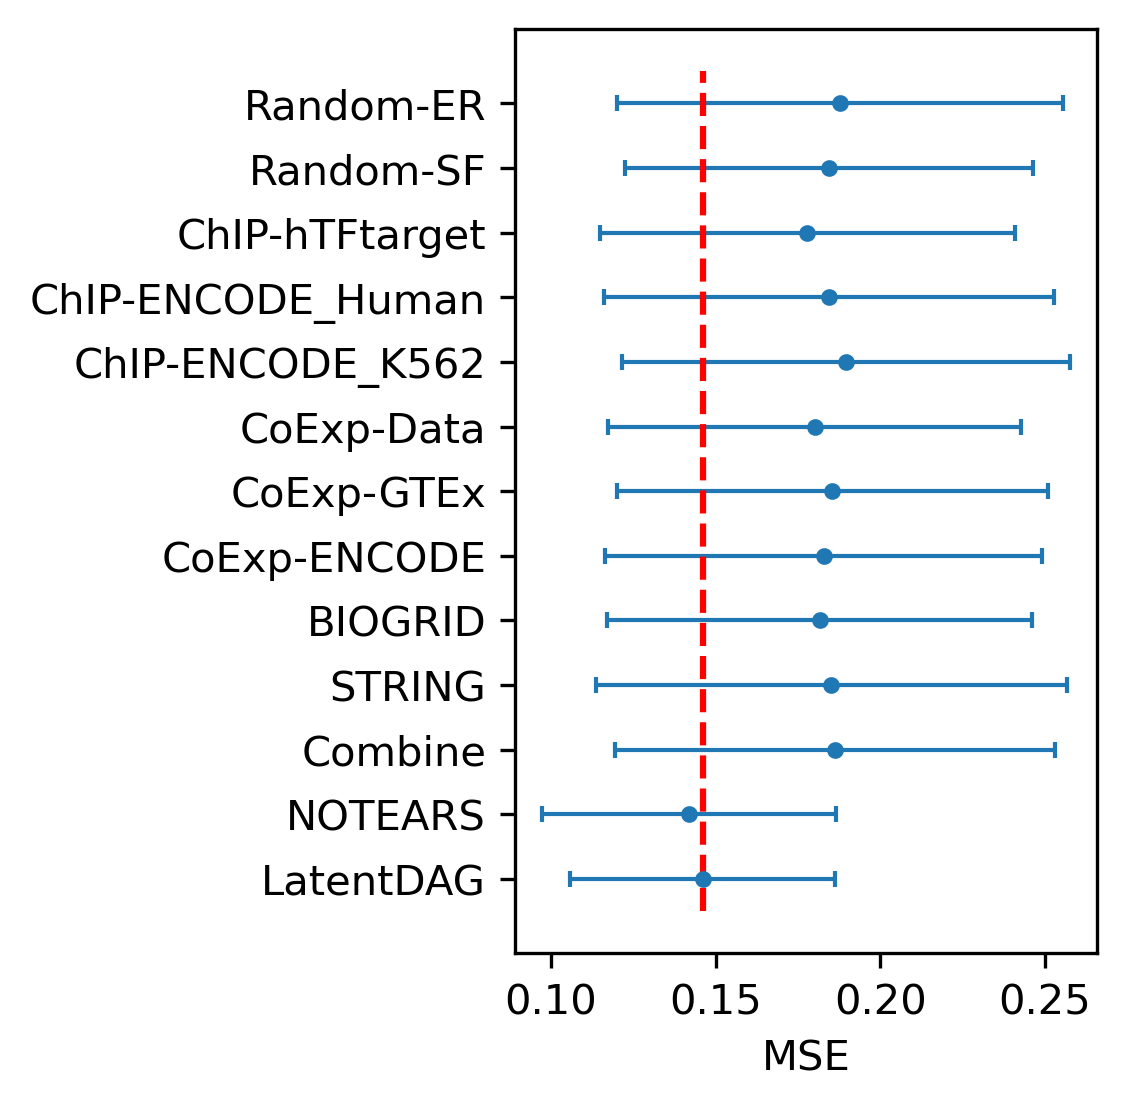

In [4]:
mean_mse = []
std_mse = []
for ii in range(13):
    mean_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("MSE")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS7_GAT_mse.pdf", dpi="figure", bbox_inches="tight")

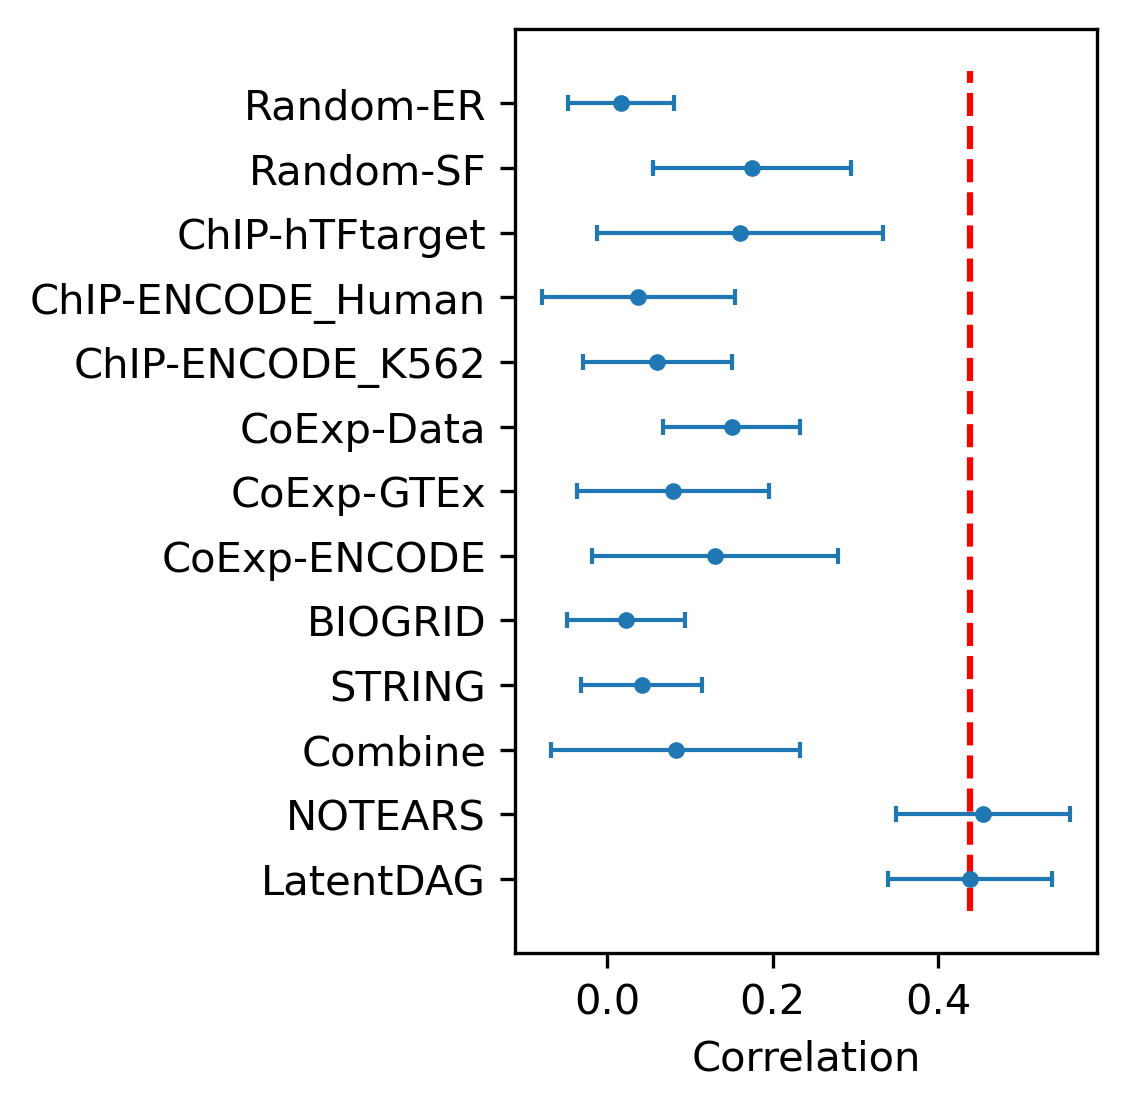

In [5]:
mean_mse = []
std_mse = []
for ii in range(13):
    mean_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("Correlation")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS7_GAT_p.pdf", dpi="figure", bbox_inches="tight")

### significance

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

In [7]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=4.906633852461745, pvalue=2.767459824373645e-06)
Ttest_indResult(statistic=5.088166195600564, pvalue=1.0024900449772516e-06)
Ttest_indResult(statistic=4.159329542724222, pvalue=5.219115497249954e-05)
Ttest_indResult(statistic=4.65659518745132, pvalue=7.282427648777972e-06)
Ttest_indResult(statistic=5.37864361473603, pvalue=2.804436355375296e-07)
Ttest_indResult(statistic=4.451046479391845, pvalue=1.614523525119751e-05)
Ttest_indResult(statistic=5.0180378179176754, pvalue=1.4039608551049296e-06)
Ttest_indResult(statistic=4.660266715072078, pvalue=6.69389969219547e-06)
Ttest_indResult(statistic=4.494069213617821, pvalue=1.400320292524421e-05)
Ttest_indResult(statistic=4.547548752969613, pvalue=1.18388586864616e-05)
Ttest_indResult(statistic=5.030476374088799, pvalue=1.3753327516406344e-06)
Ttest_indResult(statistic=-0.6813743624019879, pvalue=0.49644577780437926)


In [8]:
ttest_ind_from_stats(mean1=0.16361379220214434, std1=0.061838294547170075, mean2=loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].mean(), std2=loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-1,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=0.8800073494599474, pvalue=0.3999717068465982)

In [9]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=5.245201572547953, pvalue=5.768265447857998e-07)
Ttest_indResult(statistic=5.442322592063136, pvalue=1.8018255640770088e-07)
Ttest_indResult(statistic=4.542329787103895, pvalue=1.054302705768239e-05)
Ttest_indResult(statistic=5.00816225725703, pvalue=1.4959306890376684e-06)
Ttest_indResult(statistic=5.71227379396225, pvalue=5.231869276148692e-08)
Ttest_indResult(statistic=4.824236397579706, pvalue=3.1418515131862216e-06)
Ttest_indResult(statistic=5.368210469688838, pvalue=2.6224914132955507e-07)
Ttest_indResult(statistic=5.020653659326913, pvalue=1.3047423778031328e-06)
Ttest_indResult(statistic=4.859043021343642, pvalue=2.8107946551032805e-06)
Ttest_indResult(statistic=4.89382711040973, pvalue=2.575345570739068e-06)
Ttest_indResult(statistic=5.376250646966469, pvalue=2.6275413361851156e-07)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [10]:
ttest_ind_from_stats(mean1=0.16361379220214434, std1=0.061838294547170075, mean2=loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].mean(), std2=loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-2,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=1.0814881493191568, pvalue=0.3049306931903876)

###### pearson

In [11]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-34.36848986419843, pvalue=8.696053382747445e-79)
Ttest_indResult(statistic=-16.5625274782701, pvalue=3.0772739420119894e-38)
Ttest_indResult(statistic=-13.61520440453719, pvalue=6.433857046652298e-28)
Ttest_indResult(statistic=-25.24955405240699, pvalue=1.1328189445092444e-60)
Ttest_indResult(statistic=-27.720253248044543, pvalue=3.98072157618707e-69)
Ttest_indResult(statistic=-21.877775844528834, pvalue=1.0585176991623113e-53)
Ttest_indResult(statistic=-23.068624955752394, pvalue=1.309746950209933e-56)
Ttest_indResult(statistic=-16.94770608038386, pvalue=4.0758066182296296e-38)
Ttest_indResult(statistic=-33.207594393693135, pvalue=1.486837811293609e-78)
Ttest_indResult(statistic=-31.339722306461738, pvalue=4.91481310990823e-75)
Ttest_indResult(statistic=-19.23716311970084, pvalue=1.7461637846957525e-43)
Ttest_indResult(statistic=1.0766893820219823, pvalue=0.2829413043949009)


In [12]:
ttest_ind_from_stats(mean1=0.1612640836099545, std1=0.164969210231839, mean2=p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].mean(), std2=p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-1,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=-5.219520221408928, pvalue=0.0004359085144571264)

In [13]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-34.235481007272966, pvalue=4.868160841321313e-77)
Ttest_indResult(statistic=-17.126104762769188, pvalue=4.007817439809092e-40)
Ttest_indResult(statistic=-14.170438006058346, pvalue=1.0395320222831368e-29)
Ttest_indResult(statistic=-25.602569132435683, pvalue=3.857136500095497e-62)
Ttest_indResult(statistic=-27.935132677361352, pvalue=4.187593098262454e-69)
Ttest_indResult(statistic=-22.270603645812262, pvalue=3.3938371023522323e-54)
Ttest_indResult(statistic=-23.470984521386633, pvalue=4.971253255859803e-58)
Ttest_indResult(statistic=-17.479450130002498, pvalue=5.060342521069965e-40)
Ttest_indResult(statistic=-33.147010104434834, pvalue=5.739046576805291e-77)
Ttest_indResult(statistic=-31.362794423550607, pvalue=7.806855050987224e-74)
Ttest_indResult(statistic=-19.72419504868822, pvalue=2.414909176410132e-45)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [14]:
ttest_ind_from_stats(mean1=0.1612640836099545, std1=0.164969210231839, mean2=p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].mean(), std2=p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)].std(), nobs1=10, nobs2=bool_nw[-2,:,:].sum(), equal_var=False)

Ttest_indResult(statistic=-5.502934584145268, pvalue=0.00028517440545595876)